In [1]:
#!pip install geoplot
#!pip install contextily
#!pip install altair

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import geopandas as gpd 
import nltk
nltk.download('punkt')
#import contextily as ctx
#import geoplot as gplt
#import geoplot.crs as gcrs
#import folium
#import seaborn as sns
#import altair as alt 

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Part I : Obtention du dataframe 
## 1.1.Récupération des loyers, des surfaces et de la localisation des résidences

In [3]:

df = pd.read_csv("https://data.enseignementsup-recherche.gouv.fr//explore/dataset/fr_crous_logement_france_entiere/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false", 
                 sep =';')


In [4]:
df = df[["title", "infos", "address" ,"geocalisation", "regions"]]

In [5]:
from functions_for_data_cleaning_file_modelling import *

df = get_loyer(df)
df = get_surface(df)
df = get_localisation(df) 
df

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry
0,Résidence Clairefontaine 1,Contact \nTéléphone05 56 95 55 55 \r\n \r\nEm...,13 rue Francisco Ferrer 33700 Merignac,"44.825801,-0.614005",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[20.0, 34.0, 20.0]",34.0,20.0,24.666667,-0.614005,44.825801,POINT (-0.61401 44.82580)
1,Résidence La Marne,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,99 cours de la Marne 33000 Bordeaux,"44.8295173645,-0.5666790009",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[18.0, 35.0]",35.0,18.0,26.500000,-0.566679,44.829517,POINT (-0.56668 44.82952)
2,Tauzin,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,32/36 chemin de Pomerol 33000 BORDEAUX,"44.8210868835,-0.5996379852",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.599638,44.821087,POINT (-0.59964 44.82109)
3,Condorcet,La résidence universitaire Condorcet est situé...,4 rue Peydavant 33400 TALENCE,"44.8107032776,-0.5850679874",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.585068,44.810703,POINT (-0.58507 44.81070)
4,Village n°2 rénové,Le Village 2 comprend 4 pavillons de 4 étages ...,9 Avenue Pey Berland 33600 PESSAC,"44.8009910583,-0.6108819842",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.610882,44.800991,POINT (-0.61088 44.80099)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.0,235.0,235.0000,[9.0],9.0,9.0,9.000000,1.061514,49.467331,POINT (1.06151 49.46733)
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.8,340.8,340.8000,[18.0],18.0,18.0,18.000000,1.078162,49.433716,POINT (1.07816 49.43372)
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.2,255.3,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.000000,1.067396,49.460327,POINT (1.06740 49.46033)
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.3,154.5,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.600000,-0.365822,49.194141,POINT (-0.36582 49.19414)


## 1.2.Récupération des loyers privés des communes (avec la géolocalisation des communes)

In [6]:
df_private = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da", encoding= 'unicode_escape', sep = ";")


On ne garde que le code INSEE, le nom de la ville et le loyer supérieur par m^2


In [7]:
df_private = df_private[["INSEE", "LIBGEO","upr.IPm2"]]

On renomme la colonne INSEE en codgeo pour pouvoir la merger avec la carte des contours des villes.

In [8]:
df_private.rename(columns = {'INSEE':'codgeo'}, inplace = True)

In [9]:
"""
On rajoute un 0 devant le code INSEE quand il ne fait que quatre chiffres (pour uniformiser avec l'autre base).
"""
for i in range(0,df_private.shape[0]):
    if  len(df_private["codgeo"][i]) == 4: 
            df_private["codgeo"][i] = "0" +  df_private["codgeo"][i]

In [10]:
df_private = df_private.set_index('codgeo') #on réindex le dataframe avec le code INSEE pour merger après. 

On récuppère les contours géographique des communes.(prends du temps)

In [11]:
gdf_communes_boundaries = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/e9391593-fa95-4153-aabe-87ca84d197e9")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


On ne garde que le code INSEE et les données polygoniales. 

In [12]:
gdf_communes_boundaries.rename(columns = {'INSEE_COM':'codgeo'}, inplace = True)
gdf_communes_boundaries = gdf_communes_boundaries[["codgeo", "geometry"]]
gdf_communes_boundaries = gdf_communes_boundaries.set_index('codgeo')


On concatène les deux datafarmes

In [13]:
gdf_private = pd.concat([df_private,gdf_communes_boundaries], axis = 1, join = "inner")

## 1.3. Jointures spatiales

In [14]:

#gdf_private['geometry'] = gdf_private['geometry'].apply(wkt.loads) #on transforme en format wkt (sinon ça ne marche pas)
gdf_private = gpd.GeoDataFrame(gdf_private)  #on transforme en geodataframe 
df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within 
#i.e si le point est dans le polynôme. 

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_17118/2580680376.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within


In [15]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2
0,Résidence Clairefontaine 1,Contact \nTéléphone05 56 95 55 55 \r\n \r\nEm...,13 rue Francisco Ferrer 33700 Merignac,"44.825801,-0.614005",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[20.0, 34.0, 20.0]",34.0,20.0,24.666667,-0.614005,44.825801,POINT (-0.61401 44.82580),Mérignac,"15,48723264"
1,Résidence La Marne,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,99 cours de la Marne 33000 Bordeaux,"44.8295173645,-0.5666790009",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[18.0, 35.0]",35.0,18.0,26.500000,-0.566679,44.829517,POINT (-0.56668 44.82952),Bordeaux,"18,35356354"
2,Tauzin,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,32/36 chemin de Pomerol 33000 BORDEAUX,"44.8210868835,-0.5996379852",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.599638,44.821087,POINT (-0.59964 44.82109),Bordeaux,"18,35356354"
3,Condorcet,La résidence universitaire Condorcet est situé...,4 rue Peydavant 33400 TALENCE,"44.8107032776,-0.5850679874",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.585068,44.810703,POINT (-0.58507 44.81070),Talence,"16,65335731"
4,Village n°2 rénové,Le Village 2 comprend 4 pavillons de 4 étages ...,9 Avenue Pey Berland 33600 PESSAC,"44.8009910583,-0.6108819842",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.610882,44.800991,POINT (-0.61088 44.80099),Pessac,"16,92038872"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.0,235.0,235.0000,[9.0],9.0,9.0,9.000000,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341"
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.8,340.8,340.8000,[18.0],18.0,18.0,18.000000,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357"
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.2,255.3,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.000000,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341"
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.3,154.5,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.600000,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394"


## 1.4 Ajout des départements 

In [16]:
gdf_dep = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
gdf_dep.rename(columns = {'nom':'departement'}, inplace = True)
gdf_dep = gdf_dep[["departement", "geometry"]]
gdf_dep

,departement,geometry
0,La Réunion,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...
97,Morbihan,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [17]:
df = gpd.sjoin(df, gdf_dep, how='left', op='within')


/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_17118/3352756710.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_dep, how='left', op='within')


In [18]:
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,index_right,departement
0,Résidence Clairefontaine 1,Contact \nTéléphone05 56 95 55 55 \r\n \r\nEm...,13 rue Francisco Ferrer 33700 Merignac,"44.825801,-0.614005",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[20.0, 34.0, 20.0]",34.0,20.0,24.666667,-0.614005,44.825801,POINT (-0.61401 44.82580),Mérignac,"15,48723264",28,Gironde
1,Résidence La Marne,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,99 cours de la Marne 33000 Bordeaux,"44.8295173645,-0.5666790009",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[18.0, 35.0]",35.0,18.0,26.500000,-0.566679,44.829517,POINT (-0.56668 44.82952),Bordeaux,"18,35356354",28,Gironde
2,Tauzin,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,32/36 chemin de Pomerol 33000 BORDEAUX,"44.8210868835,-0.5996379852",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.599638,44.821087,POINT (-0.59964 44.82109),Bordeaux,"18,35356354",28,Gironde
3,Condorcet,La résidence universitaire Condorcet est situé...,4 rue Peydavant 33400 TALENCE,"44.8107032776,-0.5850679874",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.585068,44.810703,POINT (-0.58507 44.81070),Talence,"16,65335731",28,Gironde
4,Village n°2 rénové,Le Village 2 comprend 4 pavillons de 4 étages ...,9 Avenue Pey Berland 33600 PESSAC,"44.8009910583,-0.6108819842",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.610882,44.800991,POINT (-0.61088 44.80099),Pessac,"16,92038872",28,Gironde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.0,235.0,235.0000,[9.0],9.0,9.0,9.000000,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341",9,Seine-Maritime
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.8,340.8,340.8000,[18.0],18.0,18.0,18.000000,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357",9,Seine-Maritime
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.2,255.3,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.000000,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341",9,Seine-Maritime
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.3,154.5,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.600000,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394",69,Calvados


In [19]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Clairefontaine 1,Contact \nTéléphone05 56 95 55 55 \r\n \r\nEm...,13 rue Francisco Ferrer 33700 Merignac,"44.825801,-0.614005",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[20.0, 34.0, 20.0]",34.0,20.0,24.666667,-0.614005,44.825801,POINT (-0.61401 44.82580),Mérignac,"15,48723264",Gironde
1,Résidence La Marne,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,99 cours de la Marne 33000 Bordeaux,"44.8295173645,-0.5666790009",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[18.0, 35.0]",35.0,18.0,26.500000,-0.566679,44.829517,POINT (-0.56668 44.82952),Bordeaux,"18,35356354",Gironde
2,Tauzin,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,32/36 chemin de Pomerol 33000 BORDEAUX,"44.8210868835,-0.5996379852",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.599638,44.821087,POINT (-0.59964 44.82109),Bordeaux,"18,35356354",Gironde
3,Condorcet,La résidence universitaire Condorcet est situé...,4 rue Peydavant 33400 TALENCE,"44.8107032776,-0.5850679874",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.585068,44.810703,POINT (-0.58507 44.81070),Talence,"16,65335731",Gironde
4,Village n°2 rénové,Le Village 2 comprend 4 pavillons de 4 étages ...,9 Avenue Pey Berland 33600 PESSAC,"44.8009910583,-0.6108819842",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.610882,44.800991,POINT (-0.61088 44.80099),Pessac,"16,92038872",Gironde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.0,235.0,235.0000,[9.0],9.0,9.0,9.000000,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341",Seine-Maritime
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.8,340.8,340.8000,[18.0],18.0,18.0,18.000000,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357",Seine-Maritime
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.2,255.3,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.000000,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341",Seine-Maritime
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.3,154.5,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.600000,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394",Calvados


## 1.5. Association de résidences à une école 

In [20]:
df.crs = "epsg:4326" #on définit la projection de notre dataframe

In [21]:
"""
Calcul d'un cercle de 20 km autour de la résidence
"""
df1 = df
df1 = df1.to_crs(epsg = 3395) #On prend une projection en mètres
df1['geometry'] = df1['geometry'].buffer(20000) #On prend un rayon de 20km 
df1 = df1.to_crs(4326) #on repasse dans la projection uselle 
df1

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Clairefontaine 1,Contact \nTéléphone05 56 95 55 55 \r\n \r\nEm...,13 rue Francisco Ferrer 33700 Merignac,"44.825801,-0.614005",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[20.0, 34.0, 20.0]",34.0,20.0,24.666667,-0.614005,44.825801,"POLYGON ((-0.43434 44.82580, -0.43521 44.81327...",Mérignac,"15,48723264",Gironde
1,Résidence La Marne,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,99 cours de la Marne 33000 Bordeaux,"44.8295173645,-0.5666790009",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[18.0, 35.0]",35.0,18.0,26.500000,-0.566679,44.829517,"POLYGON ((-0.38702 44.82952, -0.38788 44.81698...",Bordeaux,"18,35356354",Gironde
2,Tauzin,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,32/36 chemin de Pomerol 33000 BORDEAUX,"44.8210868835,-0.5996379852",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.599638,44.821087,"POLYGON ((-0.41997 44.82109, -0.42084 44.80855...",Bordeaux,"18,35356354",Gironde
3,Condorcet,La résidence universitaire Condorcet est situé...,4 rue Peydavant 33400 TALENCE,"44.8107032776,-0.5850679874",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.585068,44.810703,"POLYGON ((-0.40540 44.81070, -0.40627 44.79817...",Talence,"16,65335731",Gironde
4,Village n°2 rénové,Le Village 2 comprend 4 pavillons de 4 étages ...,9 Avenue Pey Berland 33600 PESSAC,"44.8009910583,-0.6108819842",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],NaN,NaN,NaN,-0.610882,44.800991,"POLYGON ((-0.43122 44.80099, -0.43208 44.78845...",Pessac,"16,92038872",Gironde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.0,235.0,235.0000,[9.0],9.0,9.0,9.000000,1.061514,49.467331,"POLYGON ((1.24118 49.46733, 1.24031 49.45585, ...",Mont-Saint-Aignan,"14,84543341",Seine-Maritime
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.8,340.8,340.8000,[18.0],18.0,18.0,18.000000,1.078162,49.433716,"POLYGON ((1.25783 49.43372, 1.25696 49.42223, ...",Rouen,"14,85000357",Seine-Maritime
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.2,255.3,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.000000,1.067396,49.460327,"POLYGON ((1.24706 49.46033, 1.24619 49.44885, ...",Mont-Saint-Aignan,"14,84543341",Seine-Maritime
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.3,154.5,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.600000,-0.365822,49.194141,"POLYGON ((-0.18616 49.19414, -0.18702 49.18260...",Caen,"14,34459394",Calvados


In [22]:
"""
Import de notre base de données des écoles 
"""
df_schools = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0c713161-26fb-415e-ac1d-8769125f338d", sep = ";")

In [23]:
df_schools = df_schools[df_schools["annee_universitaire"] == "2021-22" ] #on ne prend que l'année 2021-22
df_schools = df_schools[["etablissement_lib", "effectif_sans_cpge", "etablissement_code_commune", "etablissement_commune"]]

In [24]:
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_code_commune,etablissement_commune
427,Université de Strasbourg,54534,67482,Strasbourg
428,Université Toulouse Capitole,17867,31555,Toulouse
429,École nationale supérieure des sciences de l'i...,234,69266,Villeurbanne
430,Université Paris 1 - Panthéon Sorbonne,40413,75105,Paris 5e
431,Université Jean Moulin - Lyon 3,25559,69387,Lyon 7e
...,...,...,...,...
2283,École nationale supérieure de l'électronique e...,874,95127,Cergy
2284,Université Paris-Est Créteil,39198,94028,Créteil
2285,Aix-Marseille Université,71711,13207,Marseille 7e
2286,École nationale supérieure des arts et techniq...,216,69385,Lyon 5e


In [25]:
df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


In [26]:
index_with_nan = df_schools.index[df_schools.isnull().any(axis=1)]
df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes

/tmp/ipykernel_17118/123655656.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes


In [27]:
df_schools.set_index('codgeo', inplace = True)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune
codgeo,,,
67482,Université de Strasbourg,54534,Strasbourg
31555,Université Toulouse Capitole,17867,Toulouse
69266,École nationale supérieure des sciences de l'i...,234,Villeurbanne
75105,Université Paris 1 - Panthéon Sorbonne,40413,Paris 5e
69387,Université Jean Moulin - Lyon 3,25559,Lyon 7e
...,...,...,...
95127,École nationale supérieure de l'électronique e...,874,Cergy
94028,Université Paris-Est Créteil,39198,Créteil
13207,Aix-Marseille Université,71711,Marseille 7e


In [28]:
df_schools = df_schools.join(gdf_communes_boundaries)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune,geometry
codgeo,,,,
06088,Université Côte d'Azur,33537,Nice,"POLYGON ((7.32125 43.72359, 7.32113 43.72360, ..."
10387,Université de technologie de Troyes,3235,Troyes,"POLYGON ((4.05058 48.29937, 4.05137 48.29921, ..."
13001,Sciences Po Aix,1682,Aix-en-Provence,"POLYGON ((5.50459 43.53231, 5.50421 43.53234, ..."
13207,Aix-Marseille Université,71711,Marseille 7e,"MULTIPOLYGON (((5.28590 43.26396, 5.28588 43.2..."
13213,Centrale Marseille,1165,Marseille 13e,"POLYGON ((5.41084 43.31492, 5.41150 43.31484, ..."
...,...,...,...,...
97302,Université de Guyane,3890,Cayenne,"MULTIPOLYGON (((-52.16862 4.88872, -52.16870 4..."
97411,Université de La Réunion,17044,Saint-Denis,"POLYGON ((55.46906 -21.00973, 55.47105 -21.008..."
97607,Centre universitaire de Mayotte,1335,Dembeni,"POLYGON ((45.16908 -12.88110, 45.17800 -12.886..."


In [29]:
df_schools = gpd.GeoDataFrame(df_schools)
df_schools.crs = "epsg:4326"

In [30]:
"""
essai sur la résidence de Cergy 
"""
a = df_schools.within(df1["geometry"][1])
i = 0 
for element in a : 
    if element == True: 
        print(df_schools['etablissement_lib'][i])
    i = i + 1

Université de Bordeaux
Bordeaux INP


In [31]:
Schools = [] #on crée une liste pour stocker la liste des écoles 
Nbstudents = [] #on crée une liste pour stocker la liste du nombre d'étudiants
Nbstudents_total  = []
for residence in df1["geometry"]: #on prend pour chaque résidence le cercle de 5 km autour de cette résidence
    S = [] #stocke les écoles pour la résidence
    N = [] #idem pour le nb d'étudiants 
    i = 0 #index 
    a = df_schools.within(residence) #On utilise gpd.within qui regarde pour chaque élèment si sa coordonnée est dans le polygone résidence
    for element in a : #on regarde pour chaque élèment de a si l'école est dans le cercle de 5km autour de la résidence
        if element == True: 
            S.append(df_schools['etablissement_lib'][i]) #on ajoute l'école de l'index i 
            N.append(df_schools['effectif_sans_cpge'][i]) #idem pour le nombre d'étudiants
        i = i + 1
    Schools.append(S) 
    Nbstudents.append(N)
    Nbstudents_total.append(sum(N))
df['Schools'] = Schools
df['Nbstudents'] = Nbstudents
df['Nbstudents_total'] = Nbstudents_total
df
       

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total
0,Résidence Clairefontaine 1,Contact \nTéléphone05 56 95 55 55 \r\n \r\nEm...,13 rue Francisco Ferrer 33700 Merignac,"44.825801,-0.614005",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[20.0, 34.0, 20.0]",...,24.666667,-0.614005,44.825801,POINT (-0.61401 44.82580),Mérignac,"15,48723264",Gironde,"[Sciences Po Bordeaux, Université Bordeaux Mon...","[2275, 15659, 51119, 2622]",71675
1,Résidence La Marne,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,99 cours de la Marne 33000 Bordeaux,"44.8295173645,-0.5666790009",Nouvelle-Aquitaine,[],NaN,NaN,NaN,"[18.0, 35.0]",...,26.500000,-0.566679,44.829517,POINT (-0.56668 44.82952),Bordeaux,"18,35356354",Gironde,"[Université de Bordeaux, Bordeaux INP]","[51119, 2622]",53741
2,Tauzin,Contact \nTéléphone05 56 90 55 55 \r\n \r\nE...,32/36 chemin de Pomerol 33000 BORDEAUX,"44.8210868835,-0.5996379852",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],...,NaN,-0.599638,44.821087,POINT (-0.59964 44.82109),Bordeaux,"18,35356354",Gironde,"[Université de Bordeaux, Bordeaux INP]","[51119, 2622]",53741
3,Condorcet,La résidence universitaire Condorcet est situé...,4 rue Peydavant 33400 TALENCE,"44.8107032776,-0.5850679874",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],...,NaN,-0.585068,44.810703,POINT (-0.58507 44.81070),Talence,"16,65335731",Gironde,"[Université de Bordeaux, Bordeaux INP]","[51119, 2622]",53741
4,Village n°2 rénové,Le Village 2 comprend 4 pavillons de 4 étages ...,9 Avenue Pey Berland 33600 PESSAC,"44.8009910583,-0.6108819842",Nouvelle-Aquitaine,[],NaN,NaN,NaN,[],...,NaN,-0.610882,44.800991,POINT (-0.61088 44.80099),Pessac,"16,92038872",Gironde,"[Sciences Po Bordeaux, Université Bordeaux Mon...","[2275, 15659, 51119, 2622]",71675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.0,235.0,235.0000,[9.0],...,9.000000,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341",Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.8,340.8,340.8000,[18.0],...,18.000000,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357",Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.2,255.3,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",...,14.000000,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341",Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.3,154.5,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",...,14.600000,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394",Calvados,[École nationale supérieure d'ingénieurs de Ca...,"[845, 32088]",32933


# II. Visualisation 

## 2.1 Portrait économique et statistique des résidences

In [32]:
df['prix_par_m2_min'] = df['Min Loyer']/df['Min Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [33]:
df["upr.IPm2"] = df["upr.IPm2"].apply(lambda x : x.replace(',', '.')) #on remplace les , par des points pour ensuite transformet cette colonne en float


In [34]:
df["upr.IPm2"] = df["upr.IPm2"].astype(float)

In [35]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_min')

/tmp/ipykernel_17118/1064917290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min
departement,,,,,,,,,,,
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333
Haute-Savoie,381.000000,301.000000,349.625000,30.000000,18.000000,24.750000,6.158333,45.918885,20.775306,0.000000,13.333333
Pyrénées-Orientales,377.166667,313.833333,346.375000,34.000000,24.200000,28.933333,2.895255,42.685872,12.694461,8569.000000,13.609152
Drôme,348.250000,269.500000,313.583333,34.500000,19.500000,28.212698,4.907664,44.927436,13.035199,0.000000,13.694444
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556
...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN
Tarn,NaN,NaN,NaN,26.750000,18.000000,22.041667,2.168522,43.842574,11.575138,2806.500000,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN


## Ajout de la colonne 'prix_par_m2_max'(qui correspond le plus souvent à des logements en colocation (T2/T3/T4))

In [36]:
df['prix_par_m2_max'] = df['Max Loyer']/df['Max Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [37]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_max')

/tmp/ipykernel_17118/2332010617.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min,prix_par_m2_max
departement,,,,,,,,,,,,
Métropole de Lyon,385.569444,297.361111,338.290509,91.000000,18.000000,48.083333,4.852971,45.754366,18.140536,110651.000000,18.250000,4.496288
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333,7.233333
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556,8.940779
Drôme,348.250000,269.500000,313.583333,34.500000,19.500000,28.212698,4.907664,44.927436,13.035199,0.000000,13.694444,10.802487
Vendée,329.635000,324.185000,326.910000,28.000000,20.000000,24.333333,-1.430032,46.670255,12.042086,0.000000,15.483000,11.448571
...,...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN,NaN
Tarn,NaN,NaN,NaN,26.750000,18.000000,22.041667,2.168522,43.842574,11.575138,2806.500000,NaN,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN,NaN


In [38]:
df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')
df_max = df_max.loc[(df_max['prix_par_m2_min']>1)] 

/tmp/ipykernel_17118/2118196628.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


In [39]:
df_max['departement'] = df_max.index #je crée une colonne qui correspond à l'index (la colonne regions)

## Ajout de la colonne 'prix_par_m2_mean'(qui correspond à la moyenne des loyers des logements porposés) 

In [40]:
df['prix_par_m2_mean'] = df['Mean Loyer']/df['Mean Surface'] # On crée une nouvelle variable prix_par_m2_mean

# Partie III : Modélisation 

Dans un premier temps nous effectuons des régressions pour essayer de prédire la variable Loyer. 

Ensuite, nous nous intéressons au prix par mètre carré des résidences crous et essaierons de déterminer si ce-dernier suit la loi de l'offre et de la demande.

In [41]:
import sys
from sklearn.linear_model import LinearRegression
import math
from functions_for_modelling import * 
#On fait directement appel aux fonctions définies dans le fichier functions_for_modelling.py pour effectuer les régressions et graphiques suivants.
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.stats.api as sms
import seaborn as sns

## III.1. Préparation du dataframe

In [42]:
"""
On créée un nouveau dataframe et on retire les valeurs manquantes pour que les régressions fonctionnent.
"""
df2 = df

In [43]:
index_with_nan = df2.index[df2.isnull().any(axis=1)] #on regarde l'index des NaN sur toutes les colonnes du dataframe

df2.drop(index_with_nan,0, inplace=True) #on retire les lignes avec des valeurs manquantes sur le dataframe df2
df2 = df2.reset_index() #On réindexe df2 pour ne pas avoir des 'sauts' dans les indexes.


print(df.shape)
print(df2.shape)

df[df['departement']=='Saône-et-Loire']

/tmp/ipykernel_17118/2364215294.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2.drop(index_with_nan,0, inplace=True) #on retire les lignes avec des valeurs manquantes sur le dataframe df2


(373, 25)
(373, 26)


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean


## III.2. Premières régressions linéaires pour expliquer la variable Loyer

### III.2.A Une première régression simple : régression du loyer maximal sur la surface maximale 

In [44]:
"""
DANS LA PREMIERE PARTIE NOUS AVONS VU QUE qu'il n'y a pas de valeurs incohérentes (min, max) qui viendraient fausser les résultats.
"""
print(df2['Max Surface'].describe())
print(df2['Max Loyer'].describe())

count    373.000000
mean      28.717614
std       16.029315
min        9.000000
25%       18.600000
50%       24.000000
75%       33.900000
max       99.000000
Name: Max Surface, dtype: float64
count    373.000000
mean     420.428874
std      113.342996
min      146.000000
25%      353.000000
50%      406.200000
75%      473.000000
max      818.020000
Name: Max Loyer, dtype: float64


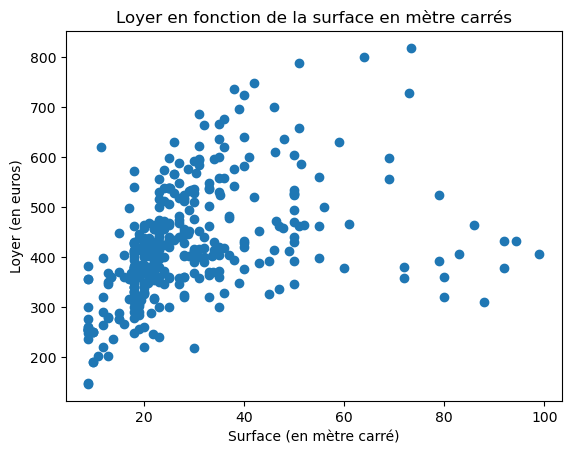

In [45]:
"""
on regarde la répartition des loyers en fonction de la surface.
"""
plt.scatter(df2['Max Surface'], df2['Max Loyer'])
plt.title('Loyer en fonction de la surface en mètre carrés')
plt.xlabel('Surface (en mètre carré)')
plt.ylabel('Loyer (en euros)')
plt.show()

In [75]:
"""

"""
print(df2['Max Loyer'].max())
get_OLS_reg(df2['Max Surface'], df2['Max Loyer'])

818.02
                            OLS Regression Results                            
Dep. Variable:              Max Loyer   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     81.68
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           8.99e-18
Time:                        16:27:03   Log-Likelihood:                -2256.1
No. Observations:                 373   AIC:                             4516.
Df Residuals:                     371   BIC:                             4524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         334.1737     10.927     30.58

(None, None)

In [47]:
#le R² de 0.18 est plutôt faible, la variable explicative (ici la surface moyenne) n'est pas très utile pour prédire le résultat. 
#La p-value indique que l'on rejette H0 à 1%, le coefficient associé à la variable Max Surface est donc significatif.
#Une hausse de 1m² de la surface entraîne une hausse de 3 euros du loyer.

#Autres remarques: Le nombre d'observations est égal à 320, ce qui est assez faible. Et la constante est assez élevée, égale à 320, 
#ce qui peut s'expliquer par la nature de la variable expliquée, le loyer, qui prend des valeurs entre 146 et 818 euros.

<AxesSubplot: xlabel='Max Surface', ylabel='Max Loyer'>

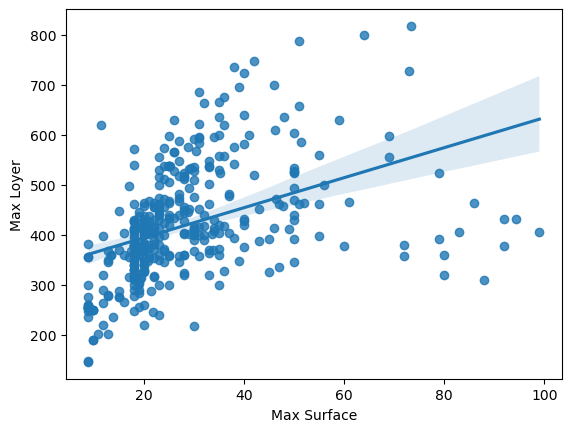

In [77]:
sns.regplot(x='Max Surface', y='Max Loyer', data=df2)

In [57]:
"""
On créé un Q-Q plot (Quantile-Quantile plot): ce type de graphe permet de voir si une variable a une distribution normale.
On compare la distribution des quantiles de l'échantillon à la distribution théorique (une droite à 45°) des quantiles d'une variable normalement distribuée.
Si les quantiles de l'échantillon des résidus (en bleu) sont sur la droite de 45° alors ils sont normalement distribués.

On affichera ensuite directement ce graphe lorsque l'on effectuera une régression avec la fonction get_OLS_reg du fichier functions_for_modelling.py.
"""
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 


NameError: name 'res' is not defined

In [59]:
#tracer résidus en fonction de y^  model.predict()

In [72]:
""" 
On effectuer les tests de Breusch-Pagan et de White afin d'avoir une indication plus précise sur l'homoscédasticité ou non des résidus.
"""
get_bp_test_OLS(df2['Max Surface'],df2['Max Loyer'])

('breusch_pagan_results=',
 {'LM Statistic': 53.8976298520684,
  'LM-Test p-value': 2.1121233733657387e-13,
  'F-Statistic': 62.663341127323754,
  'F-Test p-value': 2.866960276555661e-14})

In [61]:
#La p-value du test est inférieure à 0.05 donc le modèle semble hétéroscedastique.
#Le seul inconvénient du test de Breusch-Pagan est qu'il peut donner une faible p-value même quand le modèle n'est pas hétéroscedastique.
#En effet, si le modèle est imparfait, généralement en raison d'un biais de variable omise, le test peut alors indiquer une p-value faible.

In [62]:
"""
On effectue une régression prenant en compte une possible hétéroscedasticité des résidus avec le module RLM (Robust Linear Method) de statsmodel. 
"""
get_RLM(df2['Max Surface'],df2['Max Loyer'])

                    Robust linear Model Regression Results                    
Dep. Variable:              Max Loyer   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        16:18:04                                         
No. Iterations:                    15                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         320.2056     10.523     30.429      

In [63]:
# On remarque que l'écart type (std err) du coefficient associé à Max Surface a diminué et le coefficient reste significatif puisqu'on rejette H0 à 1% (pvalue < 0.01).
#On remarque également que l'intervalle de confiance est plus restreint.
#La régression est donc plus précise avec le module RLM.
#On privilegiera désormais le module RLM pour effectuer des régressions, puisque celui-ci prend en compte une possible hétéroscedasticité des résidus.

## III.3 On cherche maintenant à prédire le prix du mètre carré des résidences crous

### III.3.A Régression linéaire du prix du mètre carré des résidences Crous sur le prix au mètre carré des appartements privés loués. 

In [64]:
#on définit le modèle de régression linéaire de la même façon que précédemment.
get_RLM(df2['upr.IPm2'],df2['prix_par_m2_max'])

                    Robust linear Model Regression Results                    
Dep. Variable:        prix_par_m2_max   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        16:18:05                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3105      0.694     20.628      0.0

In [ ]:
#Le coefficient associé au prix du mètre carré des appartements privés loués est de 0.1283, il est significatif au seuil de 1% car la p-value<1%.
#Ainsi, une hausse de 1 euro du prix du mètre carré des appartements privés loués entraîne une hausse de 12 centimes du prix du mètre carré des résidences crous.
#La constante est de 14, ce qui paraît cohérent en réfléchissant en termes de prix au mètre carré. 

### III.3.B Régression linéaire du prix au mètre carré des résidences crous sur le nombre d'étudiants total

In [65]:
df2['Nbstudents_total'].describe()

count       373.000000
mean      92742.745308
std      111873.041768
min           0.000000
25%       10029.000000
50%       36442.000000
75%       74156.000000
max      323129.000000
Name: Nbstudents_total, dtype: float64

In [ ]:
#on constate que le minimum de la variable Nbstudents_total est de 0 ce qui signifie 

In [66]:
""" 
On crée un nouveau dataframe df_students en gardant seulement les résidences avec plus de 1000 étudiants. 
On retire ainsi en grande majorité les valeurs manquantes et les valeurs non significatives qui viendraient fausser la régression.
"""
i = df2[df2['Nbstudents_total']<=1000].index.values
df_students = df2.drop(i,axis=0)

In [67]:
get_RLM(df_students['Nbstudents_total'],df_students['prix_par_m2_max'])

                    Robust linear Model Regression Results                    
Dep. Variable:        prix_par_m2_max   No. Observations:                  321
Model:                            RLM   Df Residuals:                      319
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        16:18:06                                         
No. Iterations:                    14                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               16.4523      0.433  

Le coefficient associé au nombre d'étudiants paraît faible mais multiplié par 300 000 étudiants, il devient élevé.
La constante est assez élevée.

In [68]:
"""
On effectue une régression longue.
"""
get_RLM(df_students[['Nbstudents_total','upr.IPm2']],df_students['prix_par_m2_max']) #on ajoute l'intercept à la variable explicative. 


                    Robust linear Model Regression Results                    
Dep. Variable:        prix_par_m2_max   No. Observations:                  321
Model:                            RLM   Df Residuals:                      318
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        16:18:06                                         
No. Iterations:                    16                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.5436      1.112  

Le coefficient associé 
une augmentation de 1euro du loyer privé conduit à une augmentation de 14 centimes du loyer crous, donc les crous suivent un peu la loi du marché mais pas énormément.

On ne s'intéresse pas au nombre d'étudiants.
Il y a une petite variation en fonction du loyer de la zone mais celle-ci est très faibke. 

A la fin de cette reg, calculer le prix d'un studio de 20m2. Si on avait une surface de 20m², l'augmentation de 20 euros par mètres carré dans la ville, augmenterait le loyer du studio de 20*0.14.

A Paris, les Crous sont quand même 100 euros plus chers qu'à Dijon (cf visualisation).

C'est plutôt bien que les prix du crous ne soient pas plus sensible au nombre d'étudiants : c'est rassurant. Les résidences crous ne spéculent pas sur le nombre d'étudiants.


C'est plus rentable d'être en crous, mais les prix des crous est plus élevé dans les grandes villes que les prix au m

## III.4 L'élasticité prix du mètre carré dans les résidences crous

##### On travaille désormais avec le dataframe df_students et on s'intéresse au prix du mètre carré des résidences crous.

### III.4.A Régression linéaire 'courte' du log du prix par mètre carré dans les résidences crous sur le log du nombre d'étudiants 

In [69]:
x= np.log(df_students['Nbstudents_total'])
y= np.log(df_students['prix_par_m2_max'])
get_RLM(x,y)

                    Robust linear Model Regression Results                    
Dep. Variable:        prix_par_m2_max   No. Observations:                  321
Model:                            RLM   Df Residuals:                      319
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        16:18:07                                         
No. Iterations:                    15                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2940      0.160  

In [70]:
REGRESSION SIMPLE PRIX AU M² MAX SUR LOYER PRIV2
LA MËME SUR LE NOMBRE D'ETUDIANTS
REGRESSION LONGUE AVEC LES DEUX VARIABLES

SyntaxError: invalid character '²' (U+00B2) (3887395584.py, line 1)

In [71]:
CALCULER LE R² DE RLM
ANALYSE
model reg + score
rmse

SyntaxError: invalid character '²' (U+00B2) (2249686547.py, line 1)